# Quantifying collective identity online from self-defining hashtags: Louvain analysis code

In [1]:
# Native imports.

import os
import sys
import gzip
import pickle
import re

from time import time
from datetime import datetime
from itertools import chain, combinations, groupby
from collections import defaultdict, Counter

In [2]:
# Foreign imports.

import community # For Louvain algorithm.
import powerlaw
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyp
import matplotlib as mpl

from numpy.random import default_rng
from scipy.sparse import csr_matrix
from scipy.optimize import curve_fit, leastsq
from igraph import Graph as iGraph

In [3]:
# Matplotlib globals.

mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['font.family'] = 'serif'

In [4]:
# Colors.

deeppurple = np.array([105,68,124])/256
lime = np.array([134,196,32])/256
olive = np.array([168,186,0])/256
FINALTOPE = np.array([240,238,230])/256

## Data

In [5]:
# Load full graph edge list.

_edgeinfo = []
with gzip.open('QuantifyingCollectiveIdentity_graph_edgelist.txt.gz',
               mode='rt',
               compresslevel=9) as f:
    
    # Skip header line.
    lines = iter(f.readlines())
    _ = next(lines)
    
    d_allvidpair_sharedhashtags = dict(map(lambda x: ((int(x[0]), int(x[1])), set(x[2].split(','))),
                                        [line.strip().split(' ') for line in lines]))
    
## Weighted edges list.
all_weighted_edges = [(v0, v1, len(hts)) for (v0, v1), hts in d_allvidpair_sharedhashtags.items()]
    
## Print a selection of edges of different weights, with their hashtags.
_keys = iter(d_allvidpair_sharedhashtags.keys())
_tosee = set(range(1, 5))
_seen = set()
while _seen != _tosee:
    
    pair = next(_keys)
    hts = d_allvidpair_sharedhashtags[pair]
    weight = len(hts)
    
    if weight not in _seen and weight in _tosee:
        print(pair, hts)
        _seen.add(weight)

(59322, 30551) {'#lgrw', '#motoron', '#detroitbasketball', '#onepride'}
(73037, 30551) {'#lgrw', '#motoron', '#detroitbasketball'}
(65270, 13312) {'#ua', '#ua20'}
(89405, 11190) {'#remission'}


## Graph processing

In [6]:
# Full graph.

G = nx.Graph()
G.add_weighted_edges_from(all_weighted_edges)

# Largest component of the full graph.

Ggiant_nodeset = sorted(nx.connected_components(G), key=len, reverse=True)[0]
Ggiant = G.subgraph(Ggiant_nodeset).copy()

# Raw graph, component size CCDF

G_connected_components = sorted(nx.connected_components(G),
                                key=lambda x: len(x),
                                reverse=True)
G_connected_comp_sizes = [len(c) for c in G_connected_components]

print('Graph processing:')

print('\nOriginal graph, number of nodes: {:,}'.format(G.number_of_nodes()))
print('Original graph, number of edges: {:,}'.format(G.number_of_edges()))
print('Original graph, number of components: {:,}'.format(len(G_connected_comp_sizes)))

del G # Free memory.

print('\nGiant component, number of nodes: {:,}'.format(Ggiant.number_of_nodes()))
print('Giant component, number of edges: {:,}'.format(Ggiant.number_of_edges()))

# Make edges for Ggiant with no degree=1 nodes (the 2-core network),
# get associated data structures.

## Prune off degree=1 nodes in giant component, creating the 2-core.

deg1nodes, deg1node_degs = zip(*filter(lambda x: x[1] == 1,
                                       Ggiant.degree(list(sorted(Ggiant.nodes()))))) # list of (node, degree) tups

## Get graph without degree=1 nodes (overwriting Ggiant).
Ggiant_nodeg1_nodeset = Ggiant_nodeset - set(deg1nodes)
Ggiant = Ggiant.subgraph(Ggiant_nodeg1_nodeset).copy()

print('Degrees of nodes removed:,', set(deg1node_degs)) # Test out the actual degrees removed.
del deg1node_degs
print('\nnumber of degree=1 nodes: {:,}'.format(len(deg1nodes)))

weighted_edges = list(filter(lambda x: all(x[_k] in Ggiant_nodeg1_nodeset for _k in range(2)),
                                           all_weighted_edges))

del all_weighted_edges # Free memory.

## Get shared hashtags per vid pair for the pruned graph
## with no degree=1 nodes.

d_vidpair_sharedhashtags = dict(filter(lambda x: all(x[0][_k] in Ggiant_nodeg1_nodeset for _k in range(2)),
                                       d_allvidpair_sharedhashtags.items()))

del d_allvidpair_sharedhashtags # Free memory.

print('\nGiant component 2-core, number of nodes: {:,}'.format(Ggiant.number_of_nodes()))
print('Giant component 2-core, number of edges: {:,}'.format(Ggiant.number_of_edges()))

Graph processing:

Original graph, number of nodes: 91,093
Original graph, number of edges: 14,757,865
Original graph, number of components: 648

Giant component, number of nodes: 89,647
Giant component, number of edges: 14,756,944
Degrees of nodes removed:, {1}

number of degree=1 nodes: 3,808

Giant component 2-core, number of nodes: 85,839
Giant component 2-core, number of edges: 14,753,136


In [8]:
# Compare generative models for heavy tail in degree distribution.

data = Ggiant_degrees

fit = powerlaw.Fit(data, discrete=True)


candidates = ['power_law', 'truncated_power_law', 'exponential', 'stretched_exponential', 'lognormal']
comparr = []
for k in range(len(candidates)):
    comparr.append(['--']*len(candidates))
for i, ic in enumerate(candidates):
    for j, jc in enumerate(candidates):
        if i > j:
            Rp = '({:.2f}, {:.3f})'.format(*fit.distribution_compare(ic, jc))
            comparr[i][j] = Rp
        
comparr_df = pd.DataFrame(comparr, index=candidates, columns=candidates)

comparr_df

Calculating best minimal value for power law fit


Assuming nested distributions
Assuming nested distributions


,power_law,truncated_power_law,exponential,stretched_exponential,lognormal
power_law,--,--,--,--,--
truncated_power_law,"(54.40, 0.000)",--,--,--,--
exponential,"(27.87, 0.106)","(-26.53, 0.001)",--,--,--
stretched_exponential,"(53.55, 0.000)","(-0.85, 0.234)","(25.68, 0.000)",--,--
lognormal,"(51.45, 0.000)","(-2.95, 0.082)","(23.58, 0.008)","(-2.10, 0.040)",--


In [9]:
print(comparr_df.style.to_latex(hrules=True))

\begin{tabular}{llllll}
\toprule
 & power_law & truncated_power_law & exponential & stretched_exponential & lognormal \\
\midrule
power_law & -- & -- & -- & -- & -- \\
truncated_power_law & (54.40, 0.000) & -- & -- & -- & -- \\
exponential & (27.87, 0.106) & (-26.53, 0.001) & -- & -- & -- \\
stretched_exponential & (53.55, 0.000) & (-0.85, 0.234) & (25.68, 0.000) & -- & -- \\
lognormal & (51.45, 0.000) & (-2.95, 0.082) & (23.58, 0.008) & (-2.10, 0.040) & -- \\
\bottomrule
\end{tabular}



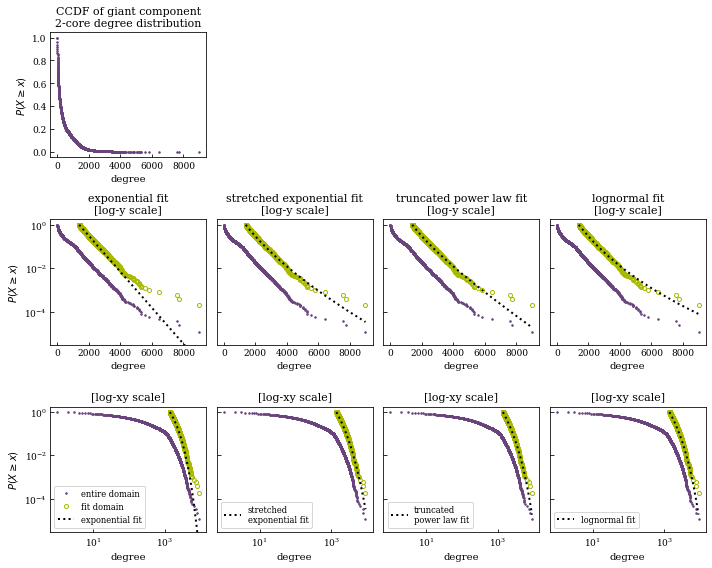

In [12]:
# Plot giant component 2-core degree distribution and fits.

Ggiant_degrees = [deg for node, deg in nx.degree(Ggiant)]

fig, axs = pyp.subplots(figsize=(10, 8), nrows=3, ncols=4)

cntsdict = Counter(Ggiant_degrees)
vals, counts = zip(*sorted(cntsdict.items(), key=lambda x: x[0]))
cumsum = np.cumsum(counts)
cdf = cumsum/cumsum[-1]
ccdf = 1 - cdf

for j in range(4):

        ax = axs[0,j]

        fit.plot_ccdf(ax=ax, original_data=True,
                      linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True, zorder=0)

        ax.set_xlabel('degree')
        ax.set_title('CCDF of giant component\n2-core degree distribution')

        ax.set_yscale('linear')
        ax.set_xscale('linear')

        ax = axs[1,j]

        #ax.plot(vals, ccdf, '.', markersize=3)

        fit.plot_ccdf(ax=ax, original_data=True,
                      linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True, zorder=0)
        fit.plot_ccdf(ax=ax,
                      linestyle='', color=olive, marker='o', markersize=4, rasterized=True, markerfacecolor='none', zorder=1)#, original_data=True)
        
        if j == 0:
            fit.exponential.plot_ccdf(ax=ax, linestyle=':', color='k', zorder=2)
        elif j == 1:
            fit.stretched_exponential.plot_ccdf(ax=ax, linestyle=':', color='k', zorder=2)
        elif j == 2:
            fit.truncated_power_law.plot_ccdf(ax=ax, linestyle=':', color='k', zorder=2)
        elif j == 3:
            fit.lognormal.plot_ccdf(ax=ax, linestyle=':', color='k', zorder=2)

        ax.set_xlabel('degree')
        
        if j == 0:
            titlepart = 'exponential fit'
        elif j == 1:
            titlepart = 'stretched exponential fit'
        elif j == 2:
            titlepart = 'truncated power law fit'
        elif j == 3:
            titlepart = 'lognormal fit'
        ax.set_title(titlepart + '\n[log-y scale]')

        ax.set_yscale('log')
        ax.set_xscale('linear')

        ax = axs[2,j]

        if j == 0:
            fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True,
                          zorder=0, label='entire domain')
            fit.plot_ccdf(ax=ax,
                          linestyle='', color=olive, marker='o', markersize=4, rasterized=True, markerfacecolor='none',
                          zorder=1, label='fit domain')#, original_data=True)
        else: # no redundant legend entries
            fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=deeppurple, marker='.', rasterized=True, markersize=3,
                          zorder=0)
            fit.plot_ccdf(ax=ax,
                          linestyle='', color=olive, marker='o', markersize=4, rasterized=True, markerfacecolor='none',
                          zorder=1)#, original_data=True)
        
        if j == 0:
            fit.exponential.plot_ccdf(ax=ax, linestyle=':', color='k',
                                                zorder=2, label='exponential fit')
        elif j == 1:
            fit.stretched_exponential.plot_ccdf(ax=ax, linestyle=':', color='k',
                                                zorder=2, label='stretched\nexponential fit')
        elif j == 2:
            fit.truncated_power_law.plot_ccdf(ax=ax, linestyle=':', color='k',
                                                zorder=2, label='truncated\npower law fit')
        elif j == 3:
            fit.truncated_power_law.plot_ccdf(ax=ax, linestyle=':', color='k',
                                                zorder=2, label='lognormal fit')

        legout = ax.legend(loc='lower left', fontsize='small')

        ax.set_xlabel('degree')
        
        ax.set_title('[log-xy scale]')

        ax.set_yscale('log')
        ax.set_xscale('log')


for i in range(3):
    axs[i,0].set_ylabel(r'$P(X \geq x)$')
for i in range(1,3):
    for j in range(0,4):
        axs[i,j].set_ylim(3e-6, 1.8)
        if j in [1,2,3]:
            axs[i,j].set_yticklabels([])
    
for j in range(1,4):
    axs[0,j].axes.remove()

fig.tight_layout()

In [ ]:
fig.savefig('degdist_2core_tailfitcomp.pdf', format='pdf', dpi=300)

## Louvain hierarchical partitioning

In [11]:
# Hierarchical modularity decomposition.

# Uncomment to find a partition from scratch, with potential
# differences from the partition used in the paper).
"""
Ggiant_partition_dendrogram = community.generate_dendrogram(Ggiant)
"""

# Alternatively, load the partition used in the paper.
with open("QuantifyingCollectiveIdentity_2core_Louvainpartitiondendrogram.pkl", mode='rb') as f:
    Ggiant_partition_dendrogram = pickle.load(f)

In [12]:
# Get projections of the first level of the Louvain hierarchy to every higher level.

## First layer mapping.
louvain_projections = [Ggiant_partition_dendrogram[0]]
## Higher layer mappings.
for level_id in range(1, len(Ggiant_partition_dendrogram)):
    
    proj = {}
    for baseid, lastlayerid in louvain_projections[level_id-1].items():
        proj[baseid] = Ggiant_partition_dendrogram[level_id][lastlayerid]
        
    louvain_projections.append(proj)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


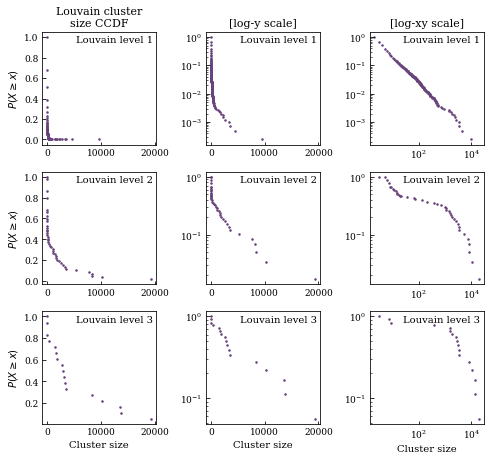

In [13]:
# Distribution of bottom-level community sizes

fig, axs = pyp.subplots(figsize=(7, 6.5), ncols=3, nrows=3)

for agglevel in range(3):

    _node_sizes = list(Counter(louvain_projections[agglevel].values()).values())

    _fit = powerlaw.Fit(_node_sizes, discrete=True)

    ax = axs[agglevel, 0]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True, zorder=0)
    

    ax.set_yscale('linear')
    ax.set_xscale('linear')

    ax.set_ylabel(r'$P(X \geq x)$')

    ax = axs[agglevel, 1]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True, zorder=0)

    ax.set_yscale('log')
    ax.set_xscale('linear')

    ax = axs[agglevel, 2]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=deeppurple, marker='.', markersize=3, rasterized=True, zorder=0)

    ax.set_yscale('log')
    ax.set_xscale('log')
    
    for ax in axs[agglevel, :]:
        ax.annotate('Louvain level {}'.format(agglevel+1),
                    xy=(0.97, 0.97), xycoords='axes fraction',
                    va='top', ha='right')

axs[0, 0].set_title('Louvain cluster\nsize CCDF')
axs[0, 1].set_title('[log-y scale]')
axs[0, 2].set_title('[log-xy scale]')
for ax in axs[2, :]:
    ax.set_xlabel('Cluster size')
    
# Set common y-axis limits for the final two axes in each row.
for k in range(3):
    these_yl0, these_yl1 = np.inf, -np.inf
    for ax in axs[k, 1:]:
        yl0, yl1 = ax.get_ylim()
        if (yl0 < these_yl0) and (yl0 > 0):
            these_yl0 = yl0
        if yl1 > these_yl1:
            these_yl1 = yl1
    for ax in axs[k, 1:]:
        ax.set_ylim(these_yl0, these_yl1)
        
# Set common x-axis limits for every column.
for k in range(3):
    these_xl0, these_xl1 = np.inf, -np.inf
    for ax in axs[:, k]:
        xl0, xl1 = ax.get_xlim()
        if (xl0 < these_xl0):
            these_xl0 = xl0
        if xl1 > these_xl1:
            these_xl1 = xl1
    for ax in axs[:, k]:
        ax.set_xlim(these_xl0, these_xl1)
    
fig.tight_layout()

## Hashtag importance scores for prototypical labels

In [8]:
def get_hashtag_importance_scores(edges_weights_tups, communities_dict, d_vpair_sharedhashtags):
    """
    Calculate modularity-related quantities of importance for hashtags.

    Args:
      edges_weights_tups (list): (vid0, vid1, weight) tuples
      communities_dict (dict): community label (int) -> set(vids)
      d_vpair_sharedhashtags (dict): (vid0, vid1) -> set(hashtags shared)

    """

    # Make dict of nodes to indices for adjacency
    node_idcs = {v:k for k, v in enumerate(set(chain(*[[t[0], t[1]] for t in edges_weights_tups])))}

    # Make adjacency matrix.  Account for (i, j) and (j, i) in matrix.
    _pre_i, _pre_j, _pre_data = zip(*edges_weights_tups)
    A_i = [node_idcs[_p_i] for _p_i in _pre_i] + [node_idcs[_p_j] for _p_j in _pre_j]
    A_j = [node_idcs[_p_j] for _p_j in _pre_j] + [node_idcs[_p_i] for _p_i in _pre_i]
    A_data = list(_pre_data) + list(_pre_data)
    A_data = np.array(A_data)
    A = csr_matrix((A_data, (A_i, A_j)))
    Ainds_tups = set(zip(A_i, A_j)) # Save for later.

    # Get non-weighted adjacency matrix, useful later.
    Aones_data = np.ones(len(A_i))

    # Make component terms of B matrix entries (the terms in modularity summand).
    m = 0.5*A_data.sum()
    k_i = np.array(A.sum(axis=1)).flatten()
    k_j = np.array(A.sum(axis=0)).flatten()

    d_hashtag_htind = {}
    hashtags_htindordered = []
    d_nodeidxpair_sharedhashtagidcs = {}
    htind = 0
    for vid0, vid1, weight in edges_weights_tups:
        vidpair = (vid0, vid1)
        sharedhashtags = d_vpair_sharedhashtags[vidpair]
        for ht in sharedhashtags:
            if ht not in d_hashtag_htind:
                d_hashtag_htind[ht] = htind
                hashtags_htindordered.append(ht)
                htind += 1

        nodeidxpair = (node_idcs[vidpair[0]], node_idcs[vidpair[1]])
        htidcs = np.array([d_hashtag_htind[ht] for ht in sharedhashtags])
        # Account for both orderings of adjacency matrix indices.
        d_nodeidxpair_sharedhashtagidcs[nodeidxpair] = htidcs
        d_nodeidxpair_sharedhashtagidcs[(nodeidxpair[1], nodeidxpair[0])] = htidcs
    hashtagcount = len(d_hashtag_htind)
    Aindsordered_sharedhtidcs = [d_nodeidxpair_sharedhashtagidcs[Ainds] \
                                      for Ainds in zip(A_i, A_j)]

    # Pre-calculate B-matrix elements in the same order as
    # zip(A_i, A_j).
    B_data = np.array([_Aij - k_i[_i]*k_j[_j]/(2*m) \
                            for _Aij, _i, _j in zip(A_data, A_i, A_j)])

    # Get mask preserving pairs within the same communities.
    # Get csr_matrix version of this as well, to easily
    # obtain the betwen-community mask later (in combination
    # with the non-weighted adjacency matrix).
    cmask_i = []
    cmask_j = []
    for commlabel, comm in communities_dict.items():
        # Iterate through the complete graph edges
        # from the community nodes.
        for vidpair in combinations(comm, 2):
            _idx0 = node_idcs[vidpair[0]]
            _idx1 = node_idcs[vidpair[1]]
            # Limit the *complete graph* edges from
            # this community to those actually in the
            # original graph.
            if (_idx0, _idx1) in Ainds_tups:
                cmask_i.extend([_idx0, _idx1])
                cmask_j.extend([_idx1, _idx0])
    cmask_i = np.array(cmask_i)
    cmask_j = np.array(cmask_j)
    cmaskinds_tups = set(zip(cmask_i, cmask_j)) # Save for later.
    cmask_data = np.ones(len(cmask_i))

    # Get mask preserving pairs BETWEEN the same communities.
    #
    # Start with non-weighted adjacency matrix, then subtract 1
    # for all pairs within the same community (already calculated).
    bmask_i = []
    bmask_j = []
    for Ainds in zip(A_i, A_j):
        if Ainds not in cmaskinds_tups:
            bmask_i.append(Ainds[0])
            bmask_j.append(Ainds[1])
    bmask_i = np.array(bmask_i)
    bmask_j = np.array(bmask_j)
    bmask_data = np.ones(len(bmask_i))

    assert len(A_data) == (len(cmask_data) + len(bmask_data)), \
            "Masks not partitioning Adjacency edges."

    # Get B-matrix entries specifically for within- and
    # between-communities edges.
    B_within_data = []
    B_between_data = []
    within_bool = []
    for Bij, Ainds in zip(B_data, zip(A_i, A_j)):
        if Ainds in cmaskinds_tups:
            B_within_data.append(Bij)
            within_bool.append(True)
        else:
            B_between_data.append(Bij)
            within_bool.append(False)

    # Create mapping from node index to community.
    d_nodeidx_commlabel = {}
    for commlabel, comm in communities_dict.items():
        for vid in comm:
            d_nodeidx_commlabel[node_idcs[vid]] = commlabel
    # Make list of relevant communities for every edge, in
    # the order of A indices.  I.e. when an edge has at
    # least one incident node within a specified community.
    Aindsordered_relevantcomms = [set([d_nodeidx_commlabel[_s] for _s in Ainds]) \
                                  for Ainds in zip(A_i, A_j)]
        
    # Pre-allocate score array for all hashtags.
    perhashtag_scores = np.zeros(hashtagcount)
    
    # Pre-allocate score arrays for all hashtags,
    # focusing on particular communities.
    allcomms = set(communities_dict.keys())
    d_commfocus_perhashtag_scores = \
            {commlabel:np.zeros(hashtagcount) for commlabel in allcomms}
    
    # Keep track of which hashtags are involved in group focus at all.
    d_commfocus_involvedhtinds = {commlabel:set([]) for commlabel in allcomms}

    # Iterate over all edges in the network, updating modularity score
    # per hashtag globally and for specific community focus.
    for Ainds, Bij, wbool, htinds, relevantcomms in zip(zip(A_i, A_j),
                                                        B_data,
                                                        within_bool,
                                                        Aindsordered_sharedhtidcs,
                                                        Aindsordered_relevantcomms):
        if wbool:
            scorepart = Bij/len(htinds)
        else:
            scorepart = -Bij/len(htinds)
            
        # Update global modularity scores for hashtags in this edge.
        # htinds is an array, so can be used as an array index below.
        perhashtag_scores[htinds] += scorepart
        
        # Update community-focused modularity scores for hashtags
        # in this edge.
        for commlabel in relevantcomms:
            d_commfocus_perhashtag_scores[commlabel][htinds] += scorepart
            d_commfocus_involvedhtinds[commlabel].update(htinds)
        
    # Apply factor to all modularity scores
    perhashtag_scores /= (4*m) # 1/4m is the normalization
                                    # factor from Newman 2006,
                                    # PNAS, "Modularity and community
                                    # structure in networks"
    for commlabel in d_commfocus_perhashtag_scores.keys():
        d_commfocus_perhashtag_scores[commlabel] /= (4*m)
        
    # Store only those hashtags and their scores per focus community
    # if they are involved with the focus community.
    d_commfocus_hashtagimpscores = {}
    for commlabel, involvedhtinds in d_commfocus_involvedhtinds.items():
        commfocus_htscores = d_commfocus_perhashtag_scores[commlabel]
        cfhashtags = [hashtags_htindordered[htind] for htind in involvedhtinds]
        cfimpscores = [commfocus_htscores[htind] for htind in involvedhtinds]
        d_commfocus_hashtagimpscores[commlabel] = dict(zip(cfhashtags, cfimpscores))

    return hashtags_htindordered, perhashtag_scores, d_commfocus_hashtagimpscores

In [9]:
# Confirm results from `get_hashtag_importance_scores` function
# against manual results from a toy graph partition.

# Test graph:
# edge: [edge elements]; adjacency weight
# (0, 1): [a, b, c]; 3
# (1, 2): [a, c];    2
# (0, 2): [a, c];    2
# (2, 3): [c];       1
# (3, 5): [a, b];    2
# (3, 4): [b, c];    2
# (4, 5): [b];       1
# (0, 3): [a, c];    2

test_weighted_edges = [(0, 1, 3),
                       (1, 2, 2),
                       (0, 2, 2),
                       (2, 3, 1),
                       (3, 5, 2),
                       (3, 4, 2),
                       (4, 5, 1),
                       (0, 3, 2)]
test_d_comm_useranid_partition = {0: set([0, 1, 2]),
                                  1: set([3, 4, 5])}
test_d_uidpair_sharedhashtags = {(0, 1): set(['a', 'b', 'c']),
                                 (1, 2): set(['a', 'c']),
                                 (0, 2): set(['a', 'c']),
                                 (2, 3): set(['c']),
                                 (3, 5): set(['a', 'b']),
                                 (3, 4): set(['b', 'c']),
                                 (4, 5): set(['b']),
                                 (0, 3): set(['a', 'c'])}

## Manual results.

_m = 30/2
_tm = 2*_m

manual_scores = {}

# a
_ascore = \
(sum([(_n - _kn/_tm)/_n for _n, _kn in zip(np.array([3, 2, 2, 2], dtype=np.float64),
                                           np.array([35, 25, 35, 21], dtype=np.float64))]) - \
sum([(_n - _kn/_tm)/_n for _n, _kn in zip(np.array([2], dtype=np.float64),
                                          np.array([49], dtype=np.float64))]))*2/(4*_m) # *2 here for two of each edge.
manual_scores['a'] = _ascore

# b
_bscore = \
(sum([(_n - _kn/_tm)/_n for _n, _kn in zip(np.array([3, 2, 2, 1], dtype=np.float64),
                                           np.array([35, 21, 21, 9], dtype=np.float64))]))*2/(4*_m)
manual_scores['b'] = _bscore

# c
_cscore = \
(sum([(_n - _kn/_tm)/_n for _n, _kn in zip(np.array([3, 2, 2, 2], dtype=np.float64),
                                           np.array([35, 25, 35, 21], dtype=np.float64))]) - \
sum([(_n - _kn/_tm)/_n for _n, _kn in zip(np.array([1, 2], dtype=np.float64), 
                                          np.array([35, 49], dtype=np.float64))]))*2/(4*_m)
manual_scores['c'] = _cscore


## Results using function.

testhashtags_htindordered, testperhashtag_scores, _ = \
        get_hashtag_importance_scores(test_weighted_edges,
                                      test_d_comm_useranid_partition,
                                      test_d_uidpair_sharedhashtags)

## Compare manual vs. function results.

print([manual_scores[_h] for _h in ['a', 'b', 'c']])

test_scores = dict(zip(testhashtags_htindordered, testperhashtag_scores))
print([test_scores[_h] for _h in ['a', 'b', 'c']])

[0.06925925925925926, 0.08703703703703702, 0.0748148148148148]
[0.06925925925925926, 0.08703703703703704, 0.07481481481481482]


### Top-level partition

In [15]:
# Get best partition of the graph (highest dendrogram level/largest communities).

Ggiant_partition = community.partition_at_level(Ggiant_partition_dendrogram, len(Ggiant_partition_dendrogram)-1)

print('{} top-level clusters'.format(len(set(Ggiant_partition.values()))))

# Get mapping of top-level communities to their contained anon. user IDs.

d_comm_useranid_Ggiant_partition = defaultdict(set)
for useranid, comm in Ggiant_partition.items():
    d_comm_useranid_Ggiant_partition[comm].add(useranid)
d_comm_useranid_Ggiant_partition = dict(d_comm_useranid_Ggiant_partition.items())

18 top-level clusters


In [14]:
# Get measure of importance of hashtags for the top-level partition.
# Should take roughly 30 minutes.

print('Starting', datetime.now())
sys.stdout.flush()

t0 = time()

hashtags_htindordered, perhashtag_scores, d_commfocus_hashtagimpscores = \
        get_hashtag_importance_scores(weighted_edges,
                                      d_comm_useranid_Ggiant_partition,
                                      d_vidpair_sharedhashtags)

tf = time()

print((tf-t0)/60, 'min.')

Starting 2022-07-26 18:25:06.581389
24.505346469084422 min.


In [15]:
# Characterize all top-level communities by hashtags imparting
# the greatest amount of modularity over all edges incident to
# each community.

agglevel = 2 # Top Louvain level.

commshowlim = 8 # Number of labels to show per community.

showN = 10 # Number of communities to show.

toplevel_commlabels_sorted, _ = zip(*sorted([(commlabel, len(comm)) for commlabel, comm in d_comm_useranid_Ggiant_partition.items()],
                                   key=lambda x: x[1],
                                   reverse=True))

_sizedict = dict(Counter(louvain_projections[agglevel].values()))
_totalsize = sum(_sizedict.values())

_ttl = 'Top {} top-level communities sorted by information user fraction'.format(showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for toplevel_commlabel in toplevel_commlabels_sorted[:showN]:
    
    print('\n++++++++++ top-level community {}: {:,} vertices, {:.3f} vertex fraction\n'.format(toplevel_commlabel,
                                                                                                _sizedict[toplevel_commlabel],
                                                                                                _sizedict[toplevel_commlabel]/_totalsize))

    focusedimpscores = sorted(d_commfocus_hashtagimpscores[toplevel_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


Top 10 top-level communities sorted by information user fraction


++++++++++ top-level community 8: 19,337 vertices, 0.225 vertex fraction

#flyeaglesfly
#lakeshow
#cowboysnation
#coys
#lakers
#bbn
#httr
#gopackgo

++++++++++ top-level community 9: 13,711 vertices, 0.160 vertex fraction

#blessed
#jucoproduct
#teamfollowback
#23
#11
#pvamu
#snapchat
#godfirst

++++++++++ top-level community 5: 13,508 vertices, 0.157 vertex fraction

#writer
#author
#gamer
#artist
#amwriting
#mentalhealth
#actor
#blogger

++++++++++ top-level community 1: 10,253 vertices, 0.119 vertex fraction

#marketing
#tech
#socialmedia
#entrepreneur
#ai
#digital
#innovation
#blockchain

++++++++++ top-level community 6: 8,352 vertices, 0.097 vertex fraction

#music
#travel
#love
#photography
#food
#fitness
#family
#scicomm

++++++++++ top-level community 2: 3,530 vertices, 0.041 vertex fraction

#resist
#theresistance
#fbr
#resistance
#bluewave
#impeachtrump
#metoo
#notmypresident

++++++++++ top-level community 

### Bottom-level partition

In [16]:
# Get mapping of first-level communities to their contained anon. user IDs.

d_comm_useranid_Ggiant_firstlevel_partition = defaultdict(set)
for useranid, comm in louvain_projections[0].items():
    d_comm_useranid_Ggiant_firstlevel_partition[comm].add(useranid)
d_comm_useranid_Ggiant_firstlevel_partition = dict(d_comm_useranid_Ggiant_firstlevel_partition.items())

In [20]:
# Get measure of importance of hashtags at the first-level partition.
# Should take roughly 30 minutes.

print('Starting', datetime.now())
sys.stdout.flush()

t0 = time()

hashtags_htindordered_firstagglevel, \
perhashtag_scores_firstagglevel, \
d_commfocus_hashtagimpscores_firstagglevel = \
        get_hashtag_importance_scores(weighted_edges,
                                      d_comm_useranid_Ggiant_firstlevel_partition,
                                      d_vidpair_sharedhashtags)

tf = time()

print((tf-t0)/60, 'min.')

Starting 2022-07-29 15:48:49.033286
23.86040266752243 min.


In [21]:
# Save/load importance scores per hashtag.

fname = 'Louvain_hashtagimportanceout_1stlvl.pkl'

# Save.
"""
with open(fname, mode='wb') as f:
    pickle.dump((hashtags_htindordered_firstagglevel, \
                 perhashtag_scores_firstagglevel, \
                 d_commfocus_hashtagimpscores_firstagglevel), f)
"""

# Load.

with open(fname, mode='rb') as f:
    hashtags_htindordered_firstagglevel, \
    perhashtag_scores_firstagglevel, \
    d_commfocus_hashtagimpscores_firstagglevel = pickle.load(f)

## Coherence

In [17]:
# Get probabilities for coherence (information gain).

assert set(chain(*d_comm_useranid_Ggiant_partition.values())) \
        == set(chain(*d_comm_useranid_Ggiant_firstlevel_partition.values())), \
            'are not partitioning the same thing'

uids_allset = set(chain(*d_comm_useranid_Ggiant_firstlevel_partition.values()))
alluidscount = len(uids_allset)

d_toplevelcomm_probs = {str(comm):len(commuids)/alluidscount \
                        for comm, commuids in d_comm_useranid_Ggiant_partition.items()}

d_firstlevel_binary_probs = {}
for firstlevel_comm, firstlevel_comm_uids in d_comm_useranid_Ggiant_firstlevel_partition.items():
    # Positive binary for this first-level community.
    d_firstlevel_binary_probs[str(firstlevel_comm)] = len(firstlevel_comm_uids)/alluidscount
    # Negative binary for this first-level community.
    d_firstlevel_binary_probs['not_{}'.format(firstlevel_comm)] = len(uids_allset - firstlevel_comm_uids)/alluidscount

d_toplevel_given_firstlevel_probs = {}
for toplevel_comm, toplevel_comm_uids in d_comm_useranid_Ggiant_partition.items():
    for firstlevel_comm, firstlevel_comm_uids in d_comm_useranid_Ggiant_firstlevel_partition.items():
        # Top-level given positive binary first-level.
        d_toplevel_given_firstlevel_probs[(str(toplevel_comm), str(firstlevel_comm))] = \
                len(firstlevel_comm_uids & toplevel_comm_uids)/len(firstlevel_comm_uids)
        # Top-level given negative binary first-level.
        d_toplevel_given_firstlevel_probs[(str(toplevel_comm), 'not_{}'.format(firstlevel_comm))] = \
                len((uids_allset - firstlevel_comm_uids) & toplevel_comm_uids)/len(uids_allset - firstlevel_comm_uids)

In [18]:
# Get binary first-level information gain on classifying top level (a.k.a. coherence).

t0 = time()

H_toplevel = - sum(_p*np.log2(_p) for _p in d_toplevelcomm_probs.values())

_firstlevel_comms = [k for k in d_firstlevel_binary_probs.keys() if '_' not in k]

d_firstlevel_binary_comm_mutinf = {}
for _firstlevel_comm in _firstlevel_comms:
    
    condH = 0
    for _firstlevel_binary_comm in [_firstlevel_comm, 'not_{}'.format(_firstlevel_comm)]:
        
        _firstlevel_binary_p = d_firstlevel_binary_probs[_firstlevel_binary_comm]

        cond_probs = [y for x, y in \
                      filter(lambda x: x[0][1] == _firstlevel_binary_comm,
                             d_toplevel_given_firstlevel_probs.items())]
        
        condH += _firstlevel_binary_p * sum(_p*np.log2(_p) for _p in cond_probs if _p > 0)
    
    # Mutual information.
    d_firstlevel_binary_comm_mutinf[_firstlevel_comm] = condH + H_toplevel

tf = time()

print((tf-t0)/60, 'min.')

3.864921776453654 min.


In [19]:
# Save/load binary first-level information gain on classifying top level

fname = 'Louvain_1stlvl_binary_comm_mutinf.pkl'

# Save
"""
with open(fname, mode='wb') as f:
    pickle.dump(d_firstlevel_binary_comm_mutinf, f)
"""
    
# Load
with open(fname, mode='rb') as f:
    d_firstlevel_binary_comm_mutinf = pickle.load(f)

In [107]:
# Characterize the first-level communities with highest coherence.

commlabels_mutinfs_sorted = sorted(d_firstlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

agglevel = 0 # First level.

commshowlim = 8

showN = 11

_sizedict = dict(Counter(louvain_projections[agglevel].values()))

_ttl = 'Top {} first-level communities sorted by information gain WRT top-level'.format(showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {:.3} bits'.format(commlabel,
                                                                                                      mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


Top 11 first-level communities sorted by information gain WRT top-level


++++++++++ local community 1:
Mut. Inf. (mean uncertainty reduction) = 0.463 bits
9582 nodes
#marketing
#tech
#socialmedia
#entrepreneur
#ai
#digital
#innovation
#blockchain

++++++++++ local community 2:
Mut. Inf. (mean uncertainty reduction) = 0.217 bits
3262 nodes
#resist
#theresistance
#fbr
#resistance
#bluewave
#impeachtrump
#metoo
#notmypresident

++++++++++ local community 29:
Mut. Inf. (mean uncertainty reduction) = 0.202 bits
4545 nodes
#disneysmmc
#adventures
#airbnb
#patience
#histmed
#healthy
#ddhh
#physical

++++++++++ local community 0:
Mut. Inf. (mean uncertainty reduction) = 0.182 bits
2684 nodes
#maga
#2a
#kag
#trump2020
#wwg1wga
#nra
#prolife
#conservative

++++++++++ local community 6:
Mut. Inf. (mean uncertainty reduction) = 0.157 bits
2267 nodes
#bts
#army
#exo
#got7
#방탄소년단
#jungkook
#nct
#taehyung

++++++++++ local community 12:
Mut. Inf. (mean uncertainty reduction) = 0.146 bits
2314 nodes

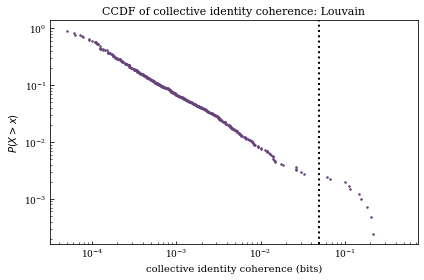

In [86]:
# Plot distribution of coherence.

_topbottomlevel_mutinfs = [x[1] for x in commlabels_mutinfs_sorted]

fig, ax = pyp.subplots()

cntsdict = Counter(_topbottomlevel_mutinfs)
vals, counts = zip(*sorted(cntsdict.items(), key=lambda x: x[0]))
cumsum = np.cumsum(counts)
cdf = cumsum/cumsum[-1]
ccdf = 1 - cdf

ax.loglog(vals, ccdf, '.', markersize=3, color=deeppurple)

yl = ax.get_ylim()
ax.loglog([0.05]*2, yl, ':k')
ax.set_ylim(yl)

ax.set_xlabel('collective identity coherence (bits)')
ax.set_ylabel(r'$P(X > x)$')
ax.set_title('CCDF of collective identity coherence: Louvain')

ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()

In [38]:
# Create DataFrame table for prototypical labels.

commlabels_mutinfs_sorted = sorted(d_firstlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

agglevel = 0 # First level.

commshowlim = 10

_sizedict = dict(Counter(louvain_projections[agglevel].values()))

top_labels_percluster = []
for commlabel, mutf in commlabels_mutinfs_sorted:
    
    if mutf > 0.05:

        intcommlabel = int(commlabel)

        focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[intcommlabel].items(),
                                  key=lambda x: x[1],
                                  reverse=True)

        zz = focusedimpscores[:commshowlim]
        
        top_labels_percluster.append(zz)
        
clusternum = len(top_labels_percluster)

chunknum = 4 # Number of topics to group into one table.

# Iterate over groups, or "chunks", of topics and
# create DataFrames for each chunk.
alphabet_labs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']
topword_dfs = []
for e in range(chunknum, clusternum+chunknum, chunknum):
    clusters_chunk = []
    for i in range(e-chunknum, e):
        if i < clusternum:
            clusters_chunk.append(top_labels_percluster[i])
        
    # Collect the top words for each topic in this chunk.
    topwordvecs = []
    for cluster in clusters_chunk:
        topwordvecs.append(np.array([z[0] for z in cluster]))

    # Combine the top words into a single DataFrame.
    topwordarr = np.vstack(topwordvecs).T
    names = ['Cluster {}'.format(alphabet_labs[k]) for k in range(e-chunknum, e, 1)[:len(topwordarr[1])]]
    topword_df = pd.DataFrame(topwordarr, columns=names)
    topword_dfs.append(topword_df)
    
# Display the first chunk's table.
topword_dfs[0]

,Cluster a,Cluster b,Cluster c,Cluster d
0,#marketing,#resist,#disneysmmc,#maga
1,#tech,#theresistance,#adventures,#2a
2,#socialmedia,#fbr,#airbnb,#kag
3,#entrepreneur,#resistance,#patience,#trump2020
4,#ai,#bluewave,#histmed,#wwg1wga
5,#digital,#impeachtrump,#healthy,#nra
6,#innovation,#metoo,#ddhh,#prolife
7,#blockchain,#notmypresident,#physical,#conservative
8,#digitalmarketing,#voteblue,#essays,#trump
9,#iot,#neveragain,#wildfire,#qanon


In [39]:
# Place all top label chunk tables into a single table.

latex_partstrings = []
for k, df in enumerate(topword_dfs):
    
    if k == 0:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[:-3]))
    
    elif k == len(topword_dfs)-1:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:]))
    
    else:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:-3]))
    
out = '\n\midrule\n'.join(latex_partstrings)

print(re.sub('#', '\\#', out))

\begin{tabular}{llll}
\toprule
Cluster a & Cluster b & Cluster c & Cluster d \\
\midrule
\#marketing & \#resist & \#disneysmmc & \#maga \\
\#tech & \#theresistance & \#adventures & \#2a \\
\#socialmedia & \#fbr & \#airbnb & \#kag \\
\#entrepreneur & \#resistance & \#patience & \#trump2020 \\
\#ai & \#bluewave & \#histmed & \#wwg1wga \\
\#digital & \#impeachtrump & \#healthy & \#nra \\
\#innovation & \#metoo & \#ddhh & \#prolife \\
\#blockchain & \#notmypresident & \#physical & \#conservative \\
\#digitalmarketing & \#voteblue & \#essays & \#trump \\
\#iot & \#neveragain & \#wildfire & \#qanon \\
\midrule
Cluster e & Cluster f & Cluster g & Cluster h \\
\midrule
\#bts & \#blacklivesmatter & \#writer & \#ynwa \\
\#army & \#blm & \#author & \#lfc \\
\#exo & \#defenddaca & \#actor & \#jft96 \\
\#got7 & \#abolishice & \#singer & \#dontbuythesun \\
\#방탄소년단 & \#allblacklivesmatter & \#producer & \#lfcfamily \\
\#jungkook & \#translivesmatter & \#poet & \#6times \\
\#nct & \#nodapl & \#songwri

## Conspicuousness

In [99]:
# Get community-focused binary hashtag probability distribution splits.
# Should take roughly 80 minutes.

# Split graph into first-level communities, get probability dists.

t0 = time()

uids_allset = set(chain(*d_comm_useranid_Ggiant_firstlevel_partition.values()))

d_commfocus_firstlevel_splitbinaryhtdists = {str(c): {str(c): {}, 'not_{}'.format(c): {}} \
                                  for c in d_comm_useranid_Ggiant_firstlevel_partition.keys()}
d_commfocus_firstlevel_splitbinaryhtcountdists = {str(c): {str(c): {}, 'not_{}'.format(c): {}} \
                                  for c in d_comm_useranid_Ggiant_firstlevel_partition.keys()}
for comm, comm_uids in d_comm_useranid_Ggiant_firstlevel_partition.items():
    
    # Hashtag probabilities for this first-level community.
    positive_comm_cdist = np.zeros(len(_voc))
    for uid in comm_uids:
        uid_hts = _d_user_hts[uid]
        positive_comm_cdist[[_d_voc_idx[ht] for ht in uid_hts]] += 1
    positive_comm_pdist = positive_comm_cdist/positive_comm_cdist.sum()

    d_commfocus_firstlevel_splitbinaryhtdists[str(comm)][str(comm)] = positive_comm_pdist
    d_commfocus_firstlevel_splitbinaryhtcountdists[str(comm)][str(comm)] = positive_comm_cdist

    # Hashtag probabilities for the complement of the first-level community.
    negative_comm_cdist = np.zeros(len(_voc))
    comm_complement_uids = uids_allset - comm_uids
    for uid in comm_complement_uids:
        uid_hts = _d_user_hts[uid]
        negative_comm_cdist[[_d_voc_idx[ht] for ht in uid_hts]] += 1
    negative_comm_pdist = negative_comm_cdist/negative_comm_cdist.sum()
    
    d_commfocus_firstlevel_splitbinaryhtdists[str(comm)]['not_{}'.format(comm)] = negative_comm_pdist
    d_commfocus_firstlevel_splitbinaryhtcountdists[str(comm)]['not_{}'.format(comm)] = negative_comm_cdist
    
tf = time()

print((tf-t0)/60, 'min.')

73.31799533764521 min.


In [100]:
def JSD(d0, d1):
    """
    d0 and d1 are 1-dimensional arrays representing
    probability distributions over the identically-ordered
    sample space.
    
    """
    
    m = d0 + d1
    
    d0_nonzero_inds = np.where(d0 != 0)
    d0p = (d0[d0_nonzero_inds]*np.log2(2*d0[d0_nonzero_inds]/m[d0_nonzero_inds])).sum()
    
    d1_nonzero_inds = np.where(d1 != 0)
    d1p = (d1[d1_nonzero_inds]*np.log2(2*d1[d1_nonzero_inds]/m[d1_nonzero_inds])).sum()
    
    return 0.5*(d0p + d1p)

In [101]:
# Get conspicuousness per bottom-level community.

d_firstlevel_comm_htinfogain = {}
for commstr, splitdict in d_commfocus_firstlevel_splitbinaryhtdists.items():
    
    d_firstlevel_comm_htinfogain[int(commstr)] = \
            JSD(splitdict[commstr], splitdict['not_' + commstr])

In [109]:
# Display hashtag info gain for first-level communities over a certain size,
# along with their prototypical labels.

_comms_infogains = sorted(d_firstlevel_comm_htinfogain.items(),
                          key=lambda x: x[1],
                          reverse=True)


agglevel = 0 # First level.

sizethresh = 600

commshowlim = 5

_sizedict = dict(Counter(louvain_projections[agglevel].values()))

_zero_uncertainty_count = 0
for _k, (firstlevel_comm, infogain) in enumerate(_comms_infogains):
    
    if infogain == 1:
        _zero_uncertainty_count += 1
        continue
        
    if _sizedict[firstlevel_comm] > sizethresh:
    
        print('\n++++++++++ Louvain first-level community {}:\n'.format(firstlevel_comm))

        firstlevel_comm_size = _sizedict[int(firstlevel_comm)]
        print('Conspicuousness: {:.3f} bits\nVertex count: {:,}\n'.format(infogain, firstlevel_comm_size))

        focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[int(firstlevel_comm)].items(),
                                  key=lambda x: x[1],
                                  reverse=True)

        zz = focusedimpscores[:commshowlim]
        print('\n'.join([z[0] for z in zz]))


++++++++++ Louvain first-level community 6:

Conspicuousness: 0.924 bits
Vertex count: 2,267

#bts
#army
#exo
#got7
#방탄소년단

++++++++++ Louvain first-level community 37:

Conspicuousness: 0.873 bits
Vertex count: 947

#lucifer
#ouat
#riverdale
#shadowhunters
#wynonnaearp

++++++++++ Louvain first-level community 9:

Conspicuousness: 0.826 bits
Vertex count: 731

#flyeaglesfly
#ttp
#eagles
#phillies
#ringthebell

++++++++++ Louvain first-level community 19:

Conspicuousness: 0.748 bits
Vertex count: 687

#lakers
#dodgers
#lakings
#ladetermined
#dodgerfam

++++++++++ Louvain first-level community 12:

Conspicuousness: 0.727 bits
Vertex count: 2,314

#blacklivesmatter
#blm
#defenddaca
#abolishice
#allblacklivesmatter

++++++++++ Louvain first-level community 0:

Conspicuousness: 0.724 bits
Vertex count: 2,684

#maga
#2a
#kag
#trump2020
#wwg1wga

++++++++++ Louvain first-level community 36:

Conspicuousness: 0.722 bits
Vertex count: 1,435

#ynwa
#lfc
#jft96
#dontbuythesun
#lfcfamily

+++++

### Null conspicuousness

In [127]:
def calculate_null_binarycommunitysplit_JSDs_preservelabelcountpools(useridx_vidcs_dict, rng_seed):
    """
    Calculate 
    
    Args:
      useridx_vidcs_dict (dict): mapping of user indices to  sets of
      vocabulary indices representing self-labels.  Both user indices
      and vocabulary indices must be integers starting at 0,
      incrementing without gap until their largest value.
    
    """
    
    rng = default_rng(rng_seed)
    
    # Randomly assign vocabulary to users, within separate pools of users
    # having 1, 2, 3, etc. labels.
    _flattened_users = []
    _flattened_vocab = []
    for lablen, lablen_users_vocab in groupby(sorted(useridx_vidcs_dict.items(),
                                                     key=lambda x: len(x[1])),
                     key=lambda x: len(x[1])):

        lablen_flattened_users = []
        lablen_flattened_vocab = []
        for lablen_user, lablen_uservocab in lablen_users_vocab:
            lablen_flattened_users.extend([lablen_user]*len(lablen_uservocab))
            lablen_flattened_vocab.extend(list(lablen_uservocab))

        # Shuffle vocab across users who have exactly lablen labels.
        rng.shuffle(lablen_flattened_vocab)

        # Extend flattened array of assigned labels to users.
        _flattened_users.extend(lablen_flattened_users)
        # Extend flattened array of users assigned to labels.
        _flattened_vocab.extend(lablen_flattened_vocab)

    # Collect shared labels to make graph.
    _null_d_userpair_sharedlabels = defaultdict(set)
    _spi = []
    _spj = []
    _spd = [] # sparse matrix: data[k] is for indices _spi[k], _spj[k]
    for vlabidx, labeluseridxpairgroup in groupby(sorted(zip(_flattened_vocab, _flattened_users),
                                                  key=lambda x: x[0]),
                                           key=lambda x: x[0]):
        _, labeluseridcs = zip(*labeluseridxpairgroup)
        # Get null shared vocab indices per user pair.
        for pair in combinations(labeluseridcs, 2):
            _null_d_userpair_sharedlabels[tuple(sorted(pair))].add(vlabidx)
        # Get null vocab index labeling per user: as arrays of vocabulary length,
        # where only the user's vocab indices = 1, the rest 0.
        for useridx in labeluseridcs:
            _spi.append(useridx)
            _spj.append(vlabidx)
            _spd.append(1)
    # Construct the null user-vocabulary sparse matrix.
    _null_user_vlabelidcs_arr = csr_matrix((_spd, (_spi, _spj)),
                                           shape=(len(useridx_vidcs_dict), len(set(_flattened_vocab))))

    # Null edges and weights for igraph representation.
    _null_edges = []
    _null_weights = []
    for e, elabs in _null_d_userpair_sharedlabels.items():
        _null_edges.append(e)
        _null_weights.append(len(elabs))

    # Construct _iG, which will be reduced to its own giant component.
    _iG = iGraph()
    _iG.add_vertices(list(useridx_vidcs_dict.keys()))
    _iG.add_edges(_null_edges)
    _iG.es['weight'] = _null_weights
    # Get all component vertex lists for _iG.
    _iGcomponents = sorted(_iG.components(mode='STRONG'), key=lambda x: len(x), reverse=True)
    # Make _iG its own giant component.
    _iG.delete_vertices(set(chain(*_iGcomponents[1:])))

    # Apply Louvain algorithm to null giant component _iG.
    louvain_partition = _iG.community_multilevel(weights='weight', return_levels=True)

    # Get 1st-level communities
    _iG_null_firstlevelcomms = louvain_partition[0] # first is 1st-level

    # Translate iGraph vertices back into their original names (before
    # deleting _iG vertices outside its own giant component - the index names
    # are the original indices given to _iG).  These original indices given to
    # _iG are the user indices.
    _d_iGvertexindices_iGoriginalnames = {iv.index:iv['name'] for iv in _iG.vs}
    _null_firstlevelcomms = []
    for _iGcomm in _iG_null_firstlevelcomms:
        _iGcomm_iGoriginalnames = [_d_iGvertexindices_iGoriginalnames[iv] for iv in _iGcomm]
        _null_firstlevelcomms.append(_iGcomm_iGoriginalnames)

    # Get vocabularies for split binary distinction of 
    # each community vs all others aggregated.  Measure the
    # JSD for each of these splits, and the associated
    # community size.
    _nulluids_allset = set(_flattened_users)
    _focus_community_sizes = []
    _focus_community_split_JSDs = []
    for comm_uids in _null_firstlevelcomms:

        # Hashtag probabilities for this first-level community.
        positive_comm_cdist = np.array(_null_user_vlabelidcs_arr[comm_uids, :].sum(axis=0)[0])
        positive_comm_pdist = positive_comm_cdist/positive_comm_cdist.sum()

        # Hashtag probabilities for the complement of the first-level community.
        comm_complement_uids = list(_nulluids_allset - set(comm_uids))
        negative_comm_cdist = np.array(_null_user_vlabelidcs_arr[comm_complement_uids, :].sum(axis=0)[0])
        negative_comm_pdist = negative_comm_cdist/negative_comm_cdist.sum()

        # Measure JSD
        d0 = positive_comm_pdist
        d1 = negative_comm_pdist
        m = d0 + d1
        d0_nonzero_inds = np.where(d0 != 0)
        d0p = (d0[d0_nonzero_inds]*np.log2(2*d0[d0_nonzero_inds]/m[d0_nonzero_inds])).sum()
        d1_nonzero_inds = np.where(d1 != 0)
        d1p = (d1[d1_nonzero_inds]*np.log2(2*d1[d1_nonzero_inds]/m[d1_nonzero_inds])).sum()
        jsd = 0.5*(d0p + d1p)
        _focus_community_split_JSDs.append(jsd)

        # Record focus community size associated with this binary
        # split JSD.
        _focus_community_sizes.append(len(comm_uids))
    
    return _focus_community_sizes, _focus_community_split_JSDs

In [130]:
# Prepare ingredients for tag-randomization null models.

# Get user -> hashtag dict.
_d_user_hts = defaultdict(set)
for uidpair, hts in d_vidpair_sharedhashtags.items():
    for uid in uidpair:
        _d_user_hts[uid].update(hts)

# Get user index -> label indices mapping for null
# calculation function.
_d_idx_vlabel = dict(enumerate(set(chain(*_d_user_hts.values()))))
_d_vlabel_idx = {v:k for k, v in _d_idx_vlabel.items()}
_d_idx_user = dict(enumerate(_d_user_hts.keys()))
_d_user_idx = {v:k for k, v in _d_idx_user.items()}
useridx_vidcs_dict = {_d_user_idx[uid]: set([_d_vlabel_idx[vl] for vl in vlabs]) \
                      for uid, vlabs in _d_user_hts.items()}

Code for null model simulation is shown in the cell below.  To load a pre-calculated null results set for 2,000 simulations, run the following cell.

In [ ]:
# Calculate tag-randomization null models.

nullcount = 100

rng_seeds = []
for k in range(nullcount):
    rng_seeds.append(int.from_bytes(os.urandom(4), byteorder='little'))

worker_ingredients = zip([useridx_vidcs_dict]*nullcount,
                         rng_seeds)

print('Starting', datetime.now())
sys.stdout.flush()

tinit = time()
t0 = tinit

nullresults = []
for nk, wtup in enumerate(worker_ingredients):
    
    nullresults.append(calculate_null_binarycommunitysplit_JSDs_preservelabelcountpools(*wtup))
    
    if (nk % 50 == 0) and nk != 0:
        tf = time()
        print('{} of {}, {:,.2f} min'.format(nk+1, nullcount, (tf-t0)/60))
        sys.stdout.flush()
        t0 = time()
        
time_taken = tf-tinit
print('Ending', datetime.now())
print('Time taken: :,.2f} min, {:,.1f} s per null'.format(time_taken/60, time_taken/nullcount))

In [142]:
# Load pre-calculated null example.

fname = "QuantifyingCollectiveIdentity_nullconspicuousness_precalc.pkl"

with open(fname, mode='rb') as f:
    nullresults = pickle.load(f)
    
print('{:,} null simulations'.format(len(nullresults)))

2,000 null simulations


In [140]:
def collect_null_jsds_by_sizebins(nullresults, binsize, minbin=1, maxbin=None,
                                  minsamplesize=100, sigalpha=0.05):

    d_null_size_binjsds = {}
    for _nullsizes, _nulljsds in nullresults:
        for _nullsize, _nulljsd in zip(_nullsizes, _nulljsds):
            if _nullsize not in d_null_size_binjsds: 
                d_null_size_binjsds[_nullsize] = [_nulljsd]
            else:
                d_null_size_binjsds[_nullsize].append(_nulljsd)

    _nullcommsizes, _nullcommjsdlists = zip(*sorted(d_null_size_binjsds.items(),
                                                  key=lambda x: x[0]))
    
    _nullcommsizes = np.array(_nullcommsizes)
    
    if not maxbin:
        maxbin = max(_nullcommsizes)

    bins = np.arange(minbin, maxbin+1, binsize)
    bin_nullcounts = []
    bin_nullCIlos = []
    bin_nullCIhis = []
    for j in range(len(bins)-1):
        bin0, bin1 = bins[j], bins[j+1]
        binned_sizes = list(range(bin0, bin1))
        binned_sizecount = 0
        binned_jsds = []
        for bs in binned_sizes:
            _idcs = np.where(_nullcommsizes == bs)[0]
            _bs_nullcommjsds = list(chain(*[_nullcommjsdlists[ix] for ix in _idcs]))
            binned_sizecount += len(_bs_nullcommjsds)
            binned_jsds.extend(_bs_nullcommjsds)
        
        bin_nullcounts.append(binned_sizecount)
        
        if len(binned_jsds) > minsamplesize:
            CIlo, CIhi = np.percentile(binned_jsds, [100*sigalpha/2, 100*(1-sigalpha/2)])
        else:
            CIlo, CIhi = np.nan, np.nan
        
        bin_nullCIlos.append(CIlo)
        bin_nullCIhis.append(CIhi)

    midbin_locs = bins[:-1] + (bins[1:] - bins[:-1])/2
    
    return bins, midbin_locs, bin_nullcounts, bin_nullCIlos, bin_nullCIhis

In [114]:
# Bin null results by community size.

binsize = 100
minsamplesize = 100

null2_bins, null2_midbin_locs, null2_bin_nullcounts, null2_bin_nullCIlos, null2_bin_nullCIhis = \
        collect_null_jsds_by_sizebins(nullresults, binsize, minbin=1, maxbin=None,
                                      minsamplesize=minsamplesize, sigalpha=0.05)

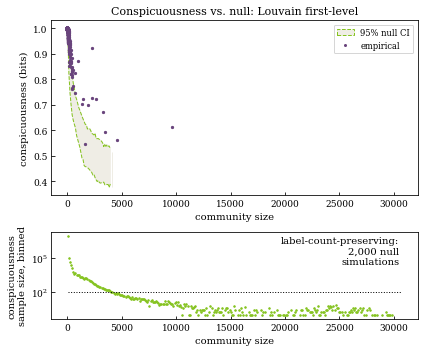

In [143]:
# Plot empirical conspicousness vs. null CI band, with number of null communities found
# per bin given the number of null simulations made.

fig = pyp.figure(figsize=(6, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 0.5])
axs = np.array([fig.add_subplot(gsp) for gsp in gs])

ax = axs[0] # Plot JSDs with null range.

_comms_infogains = sorted(d_firstlevel_comm_htinfogain.items(),
                          key=lambda x: x[1],
                          reverse=True)

_infogains = []
_sizes = []
for firstlevel_comm, infogain in _comms_infogains:
    _size = _sizedict[int(firstlevel_comm)]
    _infogains.append(infogain)
    _sizes.append(_size)
_infogains = np.array(_infogains)
_sizes = np.array(_sizes)

ax.fill_between(x=null2_midbin_locs, y1=null2_bin_nullCIlos, y2=null2_bin_nullCIhis,
                color=FINALTOPE, alpha=1, label='label-count-preserving\nnull 95% CI', zorder=0)
ax.plot(null2_midbin_locs, null2_bin_nullCIlos, linestyle='--', color=lime, linewidth=1, zorder=1)
ax.plot(null2_midbin_locs, null2_bin_nullCIhis, linestyle='--', color=lime, linewidth=1, zorder=1)

ax.scatter(_sizes, _infogains, marker='.', s=20,
           color=deeppurple, alpha=1, label='empirical', zorder=2, rasterized=True)

ax.set_ylabel('conspicuousness (bits)')
ax.set_xlabel('community size')
ax.set_title('Conspicuousness vs. null: Louvain first-level')

#legout = ax.legend(loc='best')
leglinehandles = [mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1., facecolor=FINALTOPE,
                                        linestyle='--', linewidth=1, edgecolor=lime),
                  mpl.lines.Line2D([0], [0], color=deeppurple, linewidth=0, marker='.', ms=4)]
leglinelabs = ['95% null CI',
               'empirical']
kwargs = {'loc': 'upper right', 'fontsize': 'small'}
leg = ax.legend(leglinehandles, leglinelabs, **kwargs)


ax = axs[1] # Plot the number of null jsds collected (label-count-preserving).

ax.plot(null2_midbin_locs, null2_bin_nullcounts, '.', markersize=3, color=lime, alpha=1, rasterized=True)

ax.plot(null2_midbin_locs, [minsamplesize]*len(null2_midbin_locs), 'k:', linewidth=1)

ax.annotate('label-count-preserving:\n{:,} null\nsimulations'.format(len(nullresults)),
            xy=(0.95, 0.95), xycoords="axes fraction",
            va='top', ha='right')

ax.set_yscale('log')

ax.set_ylabel('conspicuousness\nsample size, binned')
ax.set_xlabel('community size')

xmax = -1
xmin = np.inf
for ax in axs:
    xl = ax.get_xlim()
    if xl[1] > xmax:
        xmax = xl[1]
    if xl[0] < xmin:
        xmin = xl[0]
for ax in axs:
    ax.set_xlim(xmin, xmax)

fig.tight_layout()

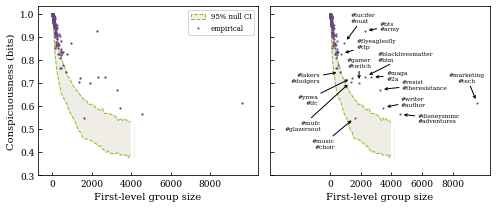

In [144]:
# Plot relationship between first-level community size and conspicuousness.
    
fig, axs = pyp.subplots(figsize=(7, 3), ncols=2, sharey=True)

commshowlim = 2

ax = axs[0]

_comms_infogains = sorted(d_firstlevel_comm_htinfogain.items(),
                          key=lambda x: x[1],
                          reverse=True)

_infogains = []
_sizes = []
for firstlevel_comm, infogain in _comms_infogains:
    _size = _sizedict[int(firstlevel_comm)]
    _infogains.append(infogain)
    _sizes.append(_size)
_infogains = np.array(_infogains)
_sizes = np.array(_sizes)

# Null.

# Limit null x-range to upper bound of 10000.
plot_null_xmax = 10000
plot_null2_midbin_locs, plot_null2_bin_nullCIlos, plot_null2_bin_nullCIhis \
        = zip(*[k for k in zip(null2_midbin_locs, null2_bin_nullCIlos, null2_bin_nullCIhis)\
                if k[0] <= plot_null_xmax])

ax.fill_between(x=plot_null2_midbin_locs, y1=plot_null2_bin_nullCIlos, y2=plot_null2_bin_nullCIhis,
                color=FINALTOPE, label='label-count-preserving\nnull 95% CI', zorder=0)
ax.plot(plot_null2_midbin_locs, plot_null2_bin_nullCIlos, linestyle='--', color=lime, linewidth=1, zorder=1)
ax.plot(plot_null2_midbin_locs, plot_null2_bin_nullCIhis, linestyle='--', color=lime, linewidth=1, zorder=1)

ax.scatter(_sizes, _infogains, marker='.', s=6,
           color=deeppurple, label='empirical', zorder=10)

# Legend.
leglinehandles = [mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1., facecolor=FINALTOPE,
                                        linestyle='--', linewidth=1, edgecolor=lime),
                  mpl.lines.Line2D([0], [0], color=deeppurple, linewidth=0, marker='.', ms=2)]
leglinelabs = ['95% null CI',
               'empirical']
kwargs = {'loc': 'upper right', 'fontsize': 'x-small'}
leg = ax.legend(leglinehandles, leglinelabs, **kwargs)

ax = axs[1]

# Null.

ax.fill_between(x=plot_null2_midbin_locs, y1=plot_null2_bin_nullCIlos, y2=plot_null2_bin_nullCIhis,
                color=FINALTOPE, zorder=0)
ax.plot(plot_null2_midbin_locs, plot_null2_bin_nullCIlos, linestyle='--', color=lime, linewidth=1, zorder=1)
ax.plot(plot_null2_midbin_locs, plot_null2_bin_nullCIhis, linestyle='--', color=lime, linewidth=1, zorder=1)

ax.scatter(_sizes, _infogains, marker='.', s=6,
           color=deeppurple, alpha=0.8, zorder=10)

# Fit model to points to influence where labels go.
def plaw(x, a, b, c):
    return a/((x + b)**c)

popt, pcov = curve_fit(plaw, sorted(_sizes), _infogains, p0=[1, 0.05, 0.01])
xfit = np.linspace(min(_sizes), max(_sizes), 30)
yfit = plaw(xfit, *popt)


# Label first-level communities.
label_info = []
for comm, infogain in _comms_infogains:
    _size = _sizedict[comm]
    if _size > 600:
        focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[comm].items(),
                              key=lambda x: x[1],
                              reverse=True)
        zz = focusedimpscores[:commshowlim]

        label = '\n'.join([z[0] for z in zz[:2]])
        
        if infogain > 0.8:
            ha = 'left'
            xoffset = 15
            yoffset = 0
        else:
            if infogain > plaw( _size, *popt):
                ha = 'left'
                xoffset = 15
                yoffset = 0
            else:
                ha = 'right'
                xoffset = -20
                yoffset = -25
                
        # Override for specific points.
        if '#blacklivesmatter' in label:
            ha = 'left'
            xoffset = 12
            yoffset = 20
        elif '#maga' in label:
            ha = 'left'
            xoffset = 15
            yoffset = 2
        elif '#lucifer' in label:
            ha = 'left'
            xoffset = 6
            yoffset = 25
        elif '#disneysmmc' in label:
            ha = 'left'
            xoffset = 18
            yoffset = -4
        elif '#resist' in label:
            ha = 'left'
            xoffset = 22
            yoffset = 5
        elif '#bts' in label:
            ha = 'left'
            xoffset = 15
            yoffset = 5
        elif '#marketing' in label:
            ha = 'center'
            xoffset = -10
            yoffset = 25
        elif '#flyeaglesfly' in label:
            ha = 'left'
            xoffset = 15
            yoffset = 10
        elif '#writer' in label:
            ha = 'left'
            xoffset = 18
            yoffset = 6
        elif '#gamer' in label:
            ha = 'center'
            xoffset = 0
            yoffset = 20
        elif '#lakers' in label:
            ha = 'right'
            xoffset = -20
            yoffset = -6
        elif '#ynwa' in label:
            ha = 'right'
            xoffset = -34
            yoffset = -22
        elif '#mufc' in label:
            ha = 'right'
            xoffset = -30
            yoffset = -44
        elif '#music' in label:
            ha = 'right'
            xoffset = -20
            yoffset = -26
        
        label_info.append(((_size, infogain), label, (xoffset, yoffset), ha))
                          
for xy, label, xyoffset, ha in label_info:
    ax.annotate(label, xy=xy, xytext=xyoffset, xycoords='data', textcoords='offset points',
                ha=ha, va='center', arrowprops={'arrowstyle':'->', 'shrinkA':1, 'shrinkB':4},
                fontsize=6, zorder=15)

axs[0].set_xlim(-700, 10400)
axs[0].set_xticks([0, 2000, 4000, 6000, 8000])
axs[0].set_xticklabels((map(str, [0, 2000, 4000, 6000, 8000])))

axs[1].set_xlim(-3900, 10400)
axs[1].set_xticks([0, 2000, 4000, 6000, 8000])
axs[1].set_xticklabels((map(str, [0, 2000, 4000, 6000, 8000])))

for ax in axs:
    ax.set_xlabel('First-level group size')
axs[0].set_ylabel('Conspicuousness (bits)')

ax.set_ylim(0.3, ax.get_ylim()[1])

fig.tight_layout()